In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import yahoo_finance as yf
import pandas_datareader as pdr
from datetime import date
from sklearn.cluster import KMeans
from statsmodels.tsa.api import adfuller
from sklearn.preprocessing import StandardScaler
from dateutil.relativedelta import relativedelta

# Modify some settings
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 16
plt.rcParams['figure.dpi'] = 150

pd.options.display.max_rows = 20
pd.options.display.max_columns = 15

In [18]:
class statarb(object):
    '''
    k-means object with ..... atributes 
    methods
    -------
        create_spread:
        check_cointergration:
        generate_signal:
        generate_returns:
        inputs: 
        attributes:
    -----
    '''
    def __init__(self, df1, df2, s1, s2, ma, floor, ceiling, stop_loss_long, stop_loss_short, beta_lookback, start, end, allocation, pair, exit_zscore=0):
        self.df1 = df1 # dataframe of stock one
        self.df2 = df2 # dataframe of stock two
        self.s1 = s1 # name of stock one
        self.s2 = s2 # name of stock two        
        self.df = pd.DataFrame(index = df1.index) # new df for data_cleaning method
        self.signals = pd.DataFrame(index = df1.index)
        self.trades = pd.DataFrame(index = df1.index)
        self.portfolio = pd.DataFrame(index = df1.index)
        self.metrics = pd.DataFrame(index = df1.index)
        self.ma = ma # moving average period
        self.floor = floor # buy threshold for z-score
        self.ceiling = ceiling # sell threshold for z-score
        self.stop_loss_long = stop_loss_long # z-score continues to drop through our floor
        self.stop_loss_short = stop_loss_short # z-score continues to rise through our ceiling 
        self.Close = 'Close Long'
        self.Cover = 'Cover Short'
        self.beta_lookback = beta_lookback # lookback of beta for hedge ratio
        self.start = start # begining of test period
        self.end = end # end of test period
        self.exit_zscore = exit_zscore # z-score
        self.allocation = allocation
        self.pair = pair
        
        self.ind = pd.MultiIndex.from_product([self.df.index, [self.s1, self.s2]], names=['Date', 'Stock'])
        self.bk = pd.DataFrame(index=self.ind)
        
        with plt.style.context(['seaborn-paper']): 
            ma1 = df1['Close'].rolling(window=self.ma).mean()
            std1 = df1['Close'].rolling(window=self.ma).std() 
            upper1 = ma1 + (std1 * 2)
            lower1 = ma1 - (std1 * 2)

            ma2 = df2['Close'].rolling(window=self.ma).mean()
            std2 = df2['Close'].rolling(window=self.ma).std() 
            upper2 = ma2 + (std2 * 2)
            lower2 = ma2 - (std2 * 2)

            plt.plot(df1['Close'],label=name_1)
            plt.plot(upper1, 'r', alpha=0.5)
            plt.plot(lower1, 'r', alpha=0.5)
            plt.plot(ma1, 'r', alpha=0.5)
            plt.fill_between(df1.index, upper1, lower1, alpha=0.1)
            plt.plot(df2['Close'],label=name_2)
            plt.plot(upper2, 'g', alpha=0.5)
            plt.plot(lower2, 'g', alpha=0.5)
            plt.plot(ma2, 'g', alpha=0.5)
            plt.fill_between(df1.index, upper2, lower2, alpha=0.1)
            plt.title(name_1 + ' and ' + name_2 + ' Over 2020 - 21')
            plt.legend(loc=0)
            plt.show()
        
    def create_spread(self):
        '''
		parameters
		----------
			self: object: statarb object
		returns
		----------
			self: df: dataframe with chosen stock prices cov, var, beta, hedge ratio and spreads
		'''
        
        # take closing price of chose stocks and add to new dataframe
        self.df[self.s1] = self.df1['Close']
        self.df[self.s2] = self.df2['Close']
        
        # find beta values for pair of stocks. This beta is not the CAPM beta, 
        # its the general beta representing the partial slope coeffiecient in a multivariate
        # (in this case univariate) regression. Given this, it also represents the min variance hedge ratio. 
        # this is a rolling regression.
        ############# need to experiment with different values for lookback window
        self.df['cov'] = self.df[self.s1].rolling(self.beta_lookback).cov(self.df[self.s2])
        self.df['var'] = self.df[self.s2].rolling(self.beta_lookback).var()
        self.df['beta'] = self.df['cov'] / self.df['var']
        
        # set hedge ratio equal to beta of pair
        self.df['Hedge_Ratio'] = self.df['beta']
        
        # the spread. For each stock_1 purchased we sell n * stock_2 where n is our hedge ratio
        # If the stocks are cointegrated, it implies the spread equation is stationary, I.E. mean and var are same over time
        # if we choose a hedge ratio such that the spread = 0, if there is cointegration the expected value of
        # the spread will stay = 0. Therefore, any deviation from this will present an opportunity of Stat Arb
        # We check for cointegration in the next method.
        self.df['Spread'] = np.log(self.df[self.s1]) - (self.df['Hedge_Ratio']*np.log(self.df[self.s2]))
        self.df['Spread_2'] = np.log(self.df[self.s2]) - (self.df['Hedge_Ratio']*np.log(self.df[self.s1]))

        return self.df
    
    def check_cointergration(self):
        '''
		parameters
		----------
			self: object: statarb object
		returns
		----------
			string: stated significance level of the chosen stock cointergration
		''' 
        ####### can imporve this method with matrix vectorization 
        # find coint
        # tells us on a given confidence level weather the par is cointegrated and thus stationary
        adf = adfuller(self.df['Spread'].dropna())
        # print appropriate response
        if adf[0] < adf[4]['1%']:
            print('Spread is Cointegrated at 1% Significance Level')
        elif adf[0] < adf[4]['5%']:
            print('Spread is Cointegrated at 5% Significance Level')
        elif adf[0] < adf[4]['10%']:
            print('Spread is Cointegrated at 10% Significance Level')
        else:
            print('Spread is not Cointegrated')
        return
    
    def generate_signal(self):
        '''
		parameters
		----------
			self: object: statarb object
		returns
		----------
			self: df: dataframe with 1 or 0 values for long, short, and exit signals, and in position markers
		''' 
        # use z scores to generate buy, sell, exit signals
        # floor and ceiling threshold should be between 1.5 and 2 sigma (change depending on backtest results)
        # LONG SIGNAL = LONG THE SPREAD: BUY STOCK 1, SELL STOCK 2
        # SHORT SIGNAL = SHORT THE SPREAD: SELL STOCK 1, BUY STOCK 2
                
        # with an assumed distribution of spread ~N(0, 1), its is easy to form threshold levels 
        # these thresholds will act as signal levels 
        # Z = (X - mean) / SD
        # given time series mean and SD will be rolling, using a moving average window
        # create stock z score of the pair spread
        self.signals['Z_Score'] = ((self.df['Spread'] - self.df['Spread'].rolling(window = self.ma).mean()) / (self.df['Spread'].rolling(window = self.ma).std()))

        # create prior stock z score        
        self.signals['Prior_Z_Score'] = self.signals['Z_Score'].shift(1)
        
        self.Short_Signal = False
        self.Long_Signal = False
        self.In_Short = False
        self.In_Long = False
        self.Stopped_Short = False
        self.Stopped_Long = False

        self.signals['Short_Signal'] = 0.0
        self.signals['Long_Signal'] = 0.0
        self.signals['In_Short'] = 0.0
        self.signals['In_Long'] = 0.0
        self.signals['Cover_Short'] = 0.0
        self.signals['Close_Long'] = 0.0

        for i, j in enumerate(self.signals.iterrows()):
            current_z = j[1]['Z_Score']
            # are we already in a short trade?
            if self.In_Short == True:
                # heave we been stopped out already?
                # define stop loss criteria
                if current_z >= self.stop_loss_short:
                    # exit trade if stop loss hit
                    # indicate we have been stopped out
                    self.In_Short = False
                    self.Stopped_Short = True
                    self.signals.iloc[i]['In_Short'] = 0.0
                    self.Short_Signal = False
                    self.signals.iloc[i]['Cover_Short'] = 1.0
                # if not stopped, have we hit close criteria?
                elif current_z <= self.exit_zscore:
                    self.In_Short = False
                    self.signals.iloc[i]['In_Short'] = 0.0
                    self.Short_Signal = False
                    self.signals.iloc[i]['Cover_Short'] = 1.0
                # if not stopped and not closed, still in trade
                else:
                    self.signals.iloc[i]['In_Short'] = 1.0
            else:
                # why are we not in a short
                # have we been stopped out or did we close position?
                if self.Stopped_Short == True:
                    self.In_Short = False
                    self.Short_Signal = False
                    self.signals.iloc[i]['In_Short'] = 0.0
                    self.signals.iloc[i]['Cover_Short'] = 1.0
                    # if stopped, wait untill we reach exit critera to re-enter teade
                    if current_z <= self.exit_zscore:
                        self.Stopped_Short = False
                # define trade entry criteria
                elif current_z >= self.ceiling:
                    self.In_Short = True
                    self.Stopped_Short = False
                    self.signals.iloc[i]['In_Short'] = 1.0
                    self.signals.iloc[i]['Cover_Short'] = 0.0
                    if self.Short_Signal == False:
                        self.signals.iloc[i]['Short_Signal'] = 1.0
                        self.Short_Signal = True

            # are we already in a long trade?
            if self.In_Long == True:
                # define stop loss criteria
                if current_z <= self.stop_loss_long:
                    # exit trade if stop loss hit
                    # indicate we have been stopped out
                    self.In_Long = False
                    self.Stopped_Long = True
                    self.signals.iloc[i]['In_Long'] = 0.0
                    self.Long_Signal = False
                    self.signals.iloc[i]['Close_Long'] = 1.0
                elif current_z >= self.exit_zscore:
                    self.In_Long = False
                    self.signals.iloc[i]['In_Long'] = 0.0
                    self.Long_Signal = False
                    self.signals.iloc[i]['Close_Long'] = 1.0
                else:
                    self.signals.iloc[i]['In_Long'] = 1.0
            else:
                # why are we not in a long
                # have we been stopped out or did we close position?
                if self.Stopped_Long == True:
                    self.In_Long = False
                    self.Long_Signal = False
                    self.signals.iloc[i]['In_Long'] = 0.0
                    self.signals.iloc[i]['Close_Long'] = 1.0
                    # if stopped, wait untill we reach exit critera to re-enter teade
                    if current_z >= self.exit_zscore:
                        self.Stopped_Long = False
                # define trade entry criteria
                elif current_z <= self.floor:
                    self.In_Long = True
                    self.Stopped_Long = False
                    self.signals.iloc[i]['In_Long'] = 1.0
                    self.signals.iloc[i]['Close_Long'] = 0.0
                    if self.Long_Signal == False:
                        self.signals.iloc[i]['Long_Signal'] = 1.0
                        self.Long_Signal = True
        
        self.df['Floor'] = self.floor
        self.df['Ceiling'] = self.ceiling
        self.df['Long_Stop_Loss'] = self.stop_loss_long
        self.df['Short_Stop_Loss'] = self.stop_loss_short
        
        with plt.style.context(['seaborn-paper']):
            plt.plot(self.signals['Z_Score'], label = 'Spread Z-Score')
            plt.plot(self.signals['In_Long'], 'g', label = 'In Long Trade')
            plt.plot(self.signals['In_Short'], 'r', label = 'In Short Trade')
            plt.plot(self.df['Floor'], 'g--', label = 'Entry Z-Score')
            plt.plot(self.df['Ceiling'], 'g--')
            plt.plot(self.df['Long_Stop_Loss'], 'r--', label = 'Stop Z-Score')
            plt.plot(self.df['Short_Stop_Loss'], 'r--')
            plt.legend(loc = 0)
            plt.tight_layout()
            plt.show()

        return self.signals
    
    def generate_trades(self):
        '''
		parameters
		----------
			self: object: statarb object
            allocation: int: desired dollar value for strategy 
            pair: string: names of two chosen stocks
		returns
		----------
			portfolio: df: dataframe with:  Positions,
                                            X,
                                            Y,
                                            Total,
                                            Returns,
                                            Win,
                                            Loss,
                                            Trade_Returns,
                                            Portfolio_Value,
                                            Portfolio_Returns,
                                            Initial_Value,
		''' 
        self.trades['Positions'] = self.signals['In_Long'] - self.signals['In_Short']
        # Long stock shows negative value = price to represent cash outflow of bought share
        # short stock shows positive value = price to represent cash inflow of borrowed shares
        self.trades[self.s1] = -1 * (self.df[self.s1] * self.trades['Positions'])
        self.trades[self.s2] = (self.df[self.s2] * self.trades['Positions'])
        # Total shows current cumulative value of positions
        self.trades['Total'] = self.trades[self.s1] + self.trades[self.s2]

        return self.trades
    
    def generate_portfolio(self):
        
        # create percentage returns stream
        # find daily change of total market value of positions
        self.portfolio['Returns'] = self.trades['Total'].pct_change()
        self.portfolio['Returns'].fillna(0.0, inplace = True)
        # account for % changes where start = 0 as this would be infinite
        self.portfolio['Returns'].replace([np.inf, -np.inf], 0.0, inplace = True)
        self.portfolio['Returns'].replace(-1.0, 0.0, inplace = True)
        
               # getting equity curve
        self.portfolio['Returns'] = (self.portfolio['Returns'] + 1.0).cumprod()
        self.portfolio['Trade_Returns'] = (self.trades['Total'].pct_change())
        self.portfolio['Portfolio_Value'] = (self.allocation * self.portfolio['Returns'])
        self.portfolio['Portfolio_Returns'] = self.portfolio['Portfolio_Value'].pct_change()
        self.portfolio['Allocation'] = self.allocation
        
        self.max_returns = np.fmax.accumulate(self.portfolio['Returns'])
        self.portfolio['Max_Drawdown'] = (self.portfolio['Returns'] / self.max_returns) - 1
        
        self.portfolio['In_Long'] = self.signals['In_Long']
        self.portfolio['In_Short'] = self.signals['In_Short']
        
        # plot portfolio valuation
        with plt.style.context(['seaborn-paper']):
            plt.plot(self.portfolio['Portfolio_Value'])
            plt.plot(self.portfolio['Allocation'])
            plt.plot(self.portfolio['In_Long']*10000, 'g', label = 'In Long Trade')
            plt.plot(self.portfolio['In_Short']*10000, 'r', label = 'In Short Trade')
            plt.legend(loc = 0)
            plt.tight_layout()
            
        return self.portfolio
    
    def generate_daily_book(self):
        
        #self.book = pd.DataFrame()
        self.book = self.bk
        self.book['Type'] = ""
        self.book['Qty'] = 0.0
        self.book['Price'] = 0.0
        self.book['Profit/Loss'] = 0.0

        for i, j in (self.book.groupby(level=0)):
            
            if self.signals.loc[i]['Long_Signal'] == 1.0:
                # set type of order
                self.book.at[(i, self.s1), 'Type'] = "Buy"
                self.book.at[(i, self.s2), 'Type'] = "Sell"
                # set quantity
                self.long_quant = np.floor((self.allocation) / self.df.loc[i][self.s1])
                self.short_quant = np.floor(self.long_quant * self.df.loc[i]['Hedge_Ratio'])
                self.book.at[(i, self.s1), 'Qty'] = self.long_quant
                self.book.at[(i, self.s2), 'Qty'] = self.short_quant
                # set stock price at order
                self.enter_long_stock_1_price = self.df.loc[i][self.s1]
                self.enter_long_stock_2_price = self.df.loc[i][self.s2]
                self.book.at[(i, self.s1), 'Price'] = self.enter_long_stock_1_price
                self.book.at[(i, self.s2), 'Price'] = self.enter_long_stock_2_price
            elif self.signals.loc[i]['Close_Long'] == 1.0:
                self.book.at[(i, self.s1), 'Type'] = 'Sell'
                self.book.at[(i, self.s2), 'Type'] = 'Buy'
                self.book.at[(i, self.s1), 'Qty'] = self.long_quant
                self.book.at[(i, self.s2), 'Qty'] = self.short_quant
                # set stock price at order
                self.exit_long_stock_1_price = self.df.loc[i][self.s1]
                self.exit_long_stock_2_price = self.df.loc[i][self.s2]
                self.book.at[(i, self.s1), 'Price'] = self.exit_long_stock_1_price
                self.book.at[(i, self.s2), 'Price'] = self.exit_long_stock_2_price
                # find profit / loss
                self.book.at[(i, self.s1), 'Profit/Loss'] = ((self.exit_long_stock_1_price - self.enter_long_stock_1_price)*self.long_quant)
                self.book.at[(i, self.s2), 'Profit/Loss'] = -1*((self.exit_long_stock_2_price - self.enter_long_stock_2_price)*self.short_quant)

            if self.signals.loc[i]['Short_Signal'] == 1.0:
                # set type of order
                self.book.at[(i, self.s1), 'Type'] = "Sell"
                self.book.at[(i, self.s2), 'Type'] = "Buy"
                # set quantity
                self.long_quant = np.floor((self.allocation) / self.df.loc[i][self.s2])
                self.short_quant = np.floor(self.long_quant * (1/self.df.loc[i]['Hedge_Ratio']))
                self.book.at[(i, self.s1), 'Qty'] = self.short_quant
                self.book.at[(i, self.s2), 'Qty'] = self.long_quant
                # set stock price at order
                self.enter_short_stock_1_price = self.df.loc[i][self.s1]
                self.enter_short_stock_2_price = self.df.loc[i][self.s2]
                self.book.at[(i, self.s1), 'Price'] = self.enter_short_stock_1_price
                self.book.at[(i, self.s2), 'Price'] = self.enter_short_stock_2_price
            elif self.signals.loc[i]['Cover_Short'] == 1.0:
                self.book.at[(i, self.s1), 'Type'] = "Buy"
                self.book.at[(i, self.s2), 'Type'] = "Sell"
                self.book.at[(i, self.s1), 'Qty'] = self.short_quant
                self.book.at[(i, self.s2), 'Qty'] = self.long_quant
                # set stock price at order
                self.exit_short_stock_1_price = self.df.loc[i][self.s1]
                self.exit_short_stock_2_price = self.df.loc[i][self.s2]
                self.book.at[(i, self.s1), 'Price'] = self.exit_short_stock_1_price
                self.book.at[(i, self.s2), 'Price'] = self.exit_short_stock_2_price
                # find profit / loss
                self.book.at[(i, self.s1), 'Profit/Loss'] = -1*((self.exit_short_stock_1_price - self.enter_short_stock_1_price)*self.short_quant)
                self.book.at[(i, self.s2), 'Profit/Loss'] = ((self.exit_short_stock_2_price - self.enter_short_stock_2_price)*self.long_quant)
        
        self.book = self.book.loc[(self.book!=0).all(axis=1)]
        
        return self.book
        
    def generate_metrics(self):
        # calculate summary statistics
        self.mu = (self.portfolio['Returns'].mean())
        self.sigma = (self.portfolio['Returns'].std())
        self.sharpe = (self.mu - 0.005) / self.sigma
        # where True, yield x, otherwise yield y
        self.wins = (np.where(self.portfolio['Returns'] > 0.0, 1.0, 0.0)).sum()
        self.losses = (np.where(self.portfolio['Returns'] < 0.0, 1.0, 0.0)).sum()
        if self.losses == 0:
            self.total_trades = self.wins
        else:
            self.total_trades = self.wins + self.lossess
        # win loss ratio
        if self.losses == 0:
            self.wl_ratio = 1
        else:
            self.wl_ratio = (self.wins / self.losses)
        # probability of win and loss
        self.p_win = (self.wins / self.total_trades)
        if self.losses == 0:
            self.p_loss = 0
        else:
            self.p_loss = (self.losses / self.total_trades)
        # avg win / loss return
        self.avg_win_return = (self.portfolio['Returns'] > 0.0).mean()
        self.avg_loss_return = (self.portfolio['Returns'] < 0.0).mean()
        # payout ratio
        if self.avg_loss_return == 0:
            self.payout_ratio = 1
        else:
            self.payout_ratio = (self.avg_win_return / self.avg_loss_return)
        
        self.difference_in_years = relativedelta(self.end, self.start).years

        self.metrics['CAGR'] = ((self.portfolio.iloc[-1]['Portfolio_Value']/self.portfolio.iloc[0]['Portfolio_Value'])**(1/self.difference_in_years)) - 1
        self.metrics['Sharpe Ratio'] = self.sharpe
        self.metrics['Wins'] = self.wins
        self.metrics['P(Wins)'] = self.p_win
        self.metrics['Avg_Win_Return'] = self.avg_win_return
        self.metrics['Losses'] = self.losses
        self.metrics['P(Loss)'] = self.p_loss
        self.metrics['Avg_Loss_Return'] = self.avg_loss_return
        self.metrics['WL_Ratio'] = self.wl_ratio
        
        return self.metrics
        

In [19]:
data = pd.read_csv('~/k_means/Data/sp_financials.csv')
data = data.drop(['SEC_Filings', 'Sector', 'Name'], axis=1)
data = data.set_index('Symbol')
data = data.fillna(0)
features = data[['Price', 'Price/Earnings', 'Dividend_Yield', 'Earnings/Share',
       '52_Week_Low', '52_Week_High', 'Market_Cap', 'EBITDA', 'Price/Sales',
       'Price/Book']]

data = StandardScaler().fit_transform(data)

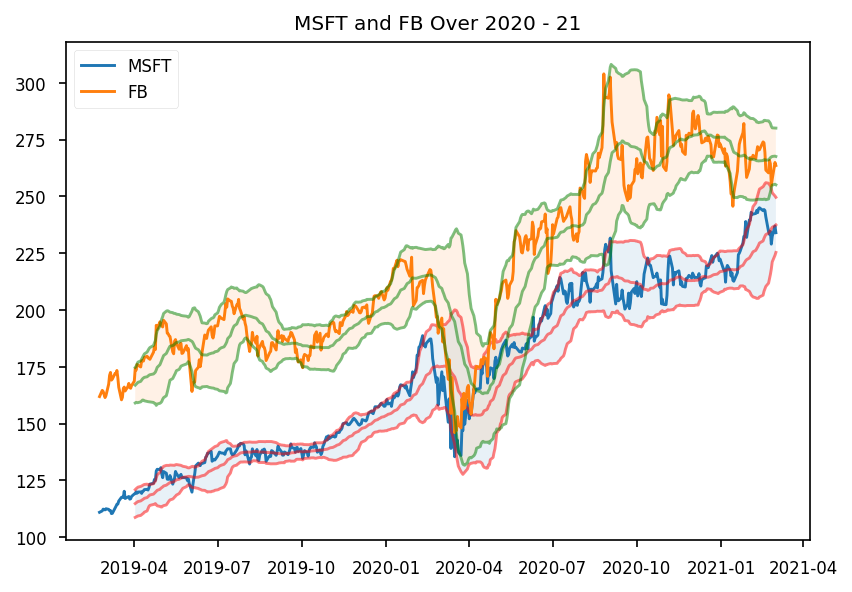

Spread is Cointegrated at 1% Significance Level


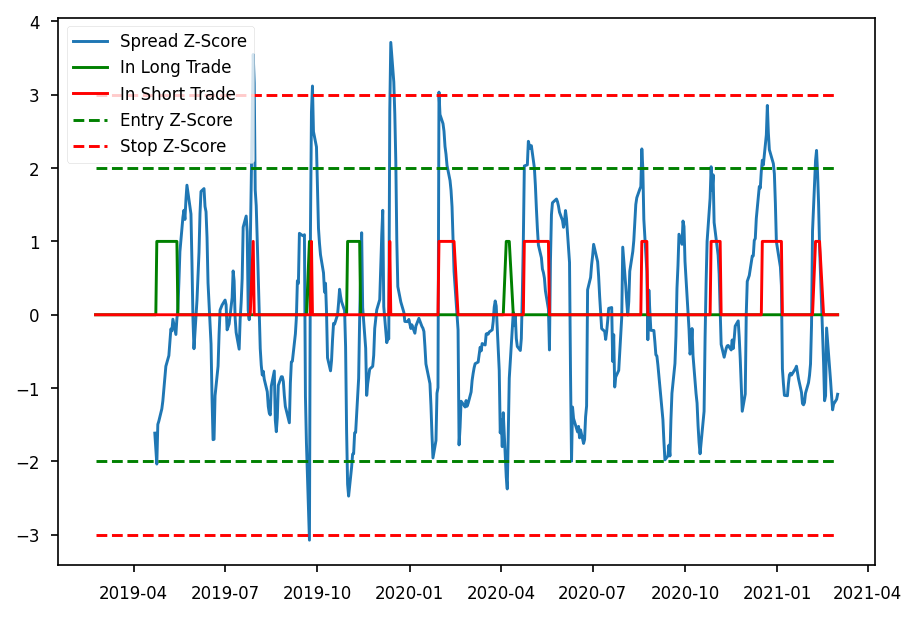

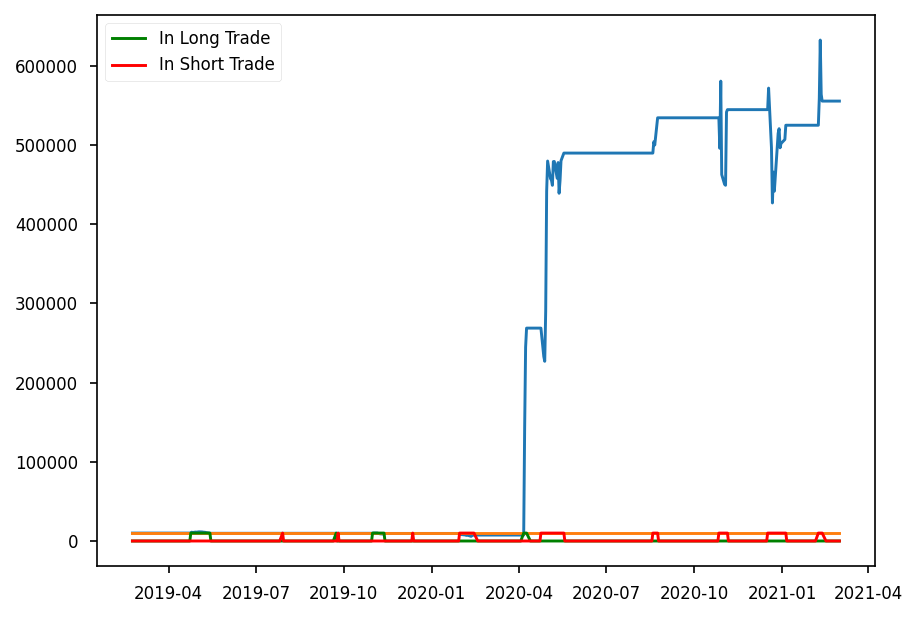

In [20]:
start = date(2019, 2, 22)
end = date.today()
name_1 = "MSFT"
name_2 = "FB"
s1 = pdr.get_data_yahoo(name_1, start, end)
s2 = pdr.get_data_yahoo(name_2, start, end)

pair = name_1 + " and " + name_2 + " Backtest"
stat_arb_object = statarb(s1, s2, name_1, name_2, 28, -2.0, 2.0, -3.0, 3.0, 14, start, end, 10000, pair)
spread = stat_arb_object.create_spread()
stat_arb_object.check_cointergration()
signals = stat_arb_object.generate_signal()
trades = stat_arb_object.generate_trades()
portfolio = stat_arb_object.generate_portfolio()
book = stat_arb_object.generate_daily_book()
numbers = stat_arb_object.generate_metrics()

In [21]:
spread

,MSFT,FB,cov,var,beta,Hedge_Ratio,Spread,Spread_2,Floor,Ceiling,Long_Stop_Loss,Short_Stop_Loss
Date,,,,,,,,,,,,
2019-02-22,110.970001,161.889999,NaN,NaN,NaN,NaN,NaN,NaN,-2.0,2.0,-3.0,3.0
2019-02-25,111.589996,164.619995,NaN,NaN,NaN,NaN,NaN,NaN,-2.0,2.0,-3.0,3.0
2019-02-26,112.360001,164.130005,NaN,NaN,NaN,NaN,NaN,NaN,-2.0,2.0,-3.0,3.0
2019-02-27,112.169998,162.809998,NaN,NaN,NaN,NaN,NaN,NaN,-2.0,2.0,-3.0,3.0
2019-02-28,112.029999,161.449997,NaN,NaN,NaN,NaN,NaN,NaN,-2.0,2.0,-3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-24,234.550003,264.309998,11.840026,16.956532,0.698258,0.698258,1.563401,1.766264,-2.0,2.0,-3.0,3.0
2021-02-25,228.990005,254.690002,23.678526,29.691448,0.797486,0.797486,1.015566,1.206763,-2.0,2.0,-3.0,3.0
2021-02-26,232.380005,257.619995,28.835492,36.058918,0.799677,0.799677,1.008978,1.194546,-2.0,2.0,-3.0,3.0


In [22]:
signals

,Z_Score,Prior_Z_Score,Short_Signal,Long_Signal,In_Short,In_Long,Cover_Short,Close_Long
Date,,,,,,,,
2019-02-22,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-25,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-26,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-27,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-28,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2021-02-24,-1.113752,-0.906783,0.0,0.0,0.0,0.0,0.0,0.0
2021-02-25,-1.296081,-1.113752,0.0,0.0,0.0,0.0,0.0,0.0
2021-02-26,-1.218969,-1.296081,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
trades

,Positions,MSFT,FB,Total
Date,,,,
2019-02-22,0.0,-0.0,0.0,0.0
2019-02-25,0.0,-0.0,0.0,0.0
2019-02-26,0.0,-0.0,0.0,0.0
2019-02-27,0.0,-0.0,0.0,0.0
2019-02-28,0.0,-0.0,0.0,0.0
...,...,...,...,...
2021-02-24,0.0,-0.0,0.0,0.0
2021-02-25,0.0,-0.0,0.0,0.0
2021-02-26,0.0,-0.0,0.0,0.0


In [24]:
portfolio

,Returns,Trade_Returns,Portfolio_Value,Portfolio_Returns,Allocation,Max_Drawdown,In_Long,In_Short
Date,,,,,,,,
2019-02-22,1.000000,NaN,10000.000000,NaN,10000,0.000000,0.0,0.0
2019-02-25,1.000000,NaN,10000.000000,0.0,10000,0.000000,0.0,0.0
2019-02-26,1.000000,NaN,10000.000000,0.0,10000,0.000000,0.0,0.0
2019-02-27,1.000000,NaN,10000.000000,0.0,10000,0.000000,0.0,0.0
2019-02-28,1.000000,NaN,10000.000000,0.0,10000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...
2021-02-24,55.565761,NaN,555657.610668,0.0,10000,-0.121859,0.0,0.0
2021-02-25,55.565761,NaN,555657.610668,0.0,10000,-0.121859,0.0,0.0
2021-02-26,55.565761,NaN,555657.610668,0.0,10000,-0.121859,0.0,0.0


In [25]:
book

Type     Qty       Price   Profit/Loss
Date       Stock                                        
2019-05-15 MSFT   Sell    79.0  126.019997     79.789566
           FB      Buy    56.0  186.270004   -206.640137
2019-07-30 MSFT    Buy  -501.0  140.350006   -340.676331
           FB     Sell    51.0  197.039993     56.099533
2019-07-31 MSFT    Buy  -501.0  136.270004  -2384.757248
...                ...     ...         ...           ...
2020-11-06 FB     Sell    35.0  293.410004    354.199829
2021-01-06 MSFT    Buy  1788.0  212.250000  12819.956726
           FB     Sell    36.0  263.309998   -402.120483
2021-02-16 MSFT    Buy   -76.0  243.699997     93.479675
           FB     Sell    37.0  273.970001    273.430542

[74 rows x 4 columns]

In [26]:
numbers.iloc[-1]

CAGR                 6.454245
Sharpe Ratio         0.914948
Wins               510.000000
P(Wins)              1.000000
Avg_Win_Return       1.000000
Losses               0.000000
P(Loss)              0.000000
Avg_Loss_Return      0.000000
WL_Ratio             1.000000
Name: 2021-03-02 00:00:00, dtype: float64